In [49]:

import numpy as np
from datetime import date, timedelta
from scipy import stats
import os
import sys
import pandas as pd
from shapely.geometry import Point
import fiona
import matplotlib.pyplot as plt
#import pdfplumber
import geopandas as gpd
import re
import json
import numpy as np
import rioxarray
import rasterio as rio
from geocube.api.core import make_geocube
import os 
import numpy
 
import rasterio as rio
import xarray as xr 
import math

from osgeo import gdal 
from rasterio.mask import mask
from shapely.geometry import mapping
import skimage.transform as st


In [154]:
wor_dir="C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model"
os.chdir(wor_dir)

admin_df =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/input/phl_admin3_simpl2.geojson')
####  admin boundary shape file 
min_lon = math.floor(admin_df.total_bounds[0])-0.1
min_lat = math.floor(admin_df.total_bounds[1])-0.1
max_lon = math.ceil(admin_df.total_bounds[2])+0.1
max_lat = math.ceil(admin_df.total_bounds[3])+0.1


### create a new unique identifier with type integer 
admin_df['ind'] = admin_df.apply(lambda row: row.adm3_pcode[2:], axis=1)
admin_df["pcode"] = admin_df.ind.astype(int)


### Pagasa data for wind return period 


In [ ]:
Wind_20_year_RR =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/WindHazard/Wind_20_year_RR.shp')
Wind_50_year_RR =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/WindHazard/Wind_50_year_RR.shp')
Wind_100_year_RR =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/WindHazard/Wind_100_year_RR.shp')
Wind_200_year_RR =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/WindHazard/Wind_200_year_RR.shp')
Wind_500_year_RR =gpd.read_file('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/WindHazard/Wind_500_year.shp')
Wind_200_year_RR  = Wind_200_year_RR.to_crs({'init': 'epsg:4326'})
Wind_500_year_RR  = Wind_500_year_RR.to_crs({'init': 'epsg:4326'})
Wind_20_year_RR  = Wind_20_year_RR.to_crs({'init': 'epsg:4326'})
Wind_50_year_RR  = Wind_50_year_RR.to_crs({'init': 'epsg:4326'})
Wind_100_year_RR  = Wind_100_year_RR.to_crs({'init': 'epsg:4326'})

df_list=[Wind_20_year_RR,
     Wind_50_year_RR,
     Wind_100_year_RR,
     Wind_200_year_RR,
     Wind_500_year_RR]

rp=[20,50,100,200,500]
wind_df=[]

for count,df in enumerate(df_list):
     df.rename(columns={'min':f'min_wind_{count}','max':f'max_wind_{count}'},inplace=True)
     gdf_lhz_cs_merged = gpd.sjoin(admin_df, df, how="left")
     df3 = gdf_lhz_cs_merged[~gdf_lhz_cs_merged.index.duplicated(keep='first')] 
     wind_df.append(df3[['adm3_pcode',f'min_wind_{count}',f'max_wind_{count}']])
     
      

wind_df1=pd.concat(wind_df, axis=1)
wind_df1 = wind_df1.loc[:,~wind_df1.columns.duplicated()]

file_path=os.path.join(wor_dir,'data/wind_data/', 'wind_return_period_pagasa.csv')
wind_df1.to_csv(file_path) 


In [162]:
#PAGASA wind data 1.49 #pagasa 1.21 #STORM
file_path=os.path.join(wor_dir,'data/wind_data/', 'wind_return_period_pagasa.csv')
pagasa_df_rp=pd.read_csv(file_path) 

#### STORM DATA

In [239]:
wor_dir="C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model"
wind =xr.open_dataset('C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/data/wind_data/input/STORM_FIXED_RETURN_PERIODS_WP.nc')


wind_df=[]

for rpt in wind.rp.values:#[20,50,100,200,500]:
    wind_rp100=wind.sel(rp=rpt).drop(['rp'])['mean'].to_dataset(name='wind').rio.write_crs("epsg:4326", inplace=True).rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    out_grid = make_geocube(
        vector_data=admin_df,
        measurements=["pcode"],
        #resolution=(0.0005, -0.0005),
        like=wind_rp100, # ensure the data are on the same grid
        # interpolate_na_method  ='nearest', 
    )
    wind_rp10=wind_rp100.drop('spatial_ref')
    wind_rp10=wind_rp10.rename({'lon': 'x','lat': 'y'})
    out_grid[f"wind__{int(rpt)}"] = (wind_rp10['wind'].dims, wind_rp10['wind'].values)
    
    zonal_stats_df = (out_grid.groupby(out_grid.pcode).max(skipna=False).to_dataframe().reset_index())
    zonal_stats_df["placeCode"] = zonal_stats_df.apply(lambda row: "PH" + str(int(row.pcode)).zfill(9), axis=1)
    wind_df.append(zonal_stats_df.drop(columns=['pcode','spatial_ref']))

    #wind_rp100=wind_rp100.rename({'lon': 'x','lat': 'y'})
    #wind_rp100=wind_rp100.drop('spatial_ref')
    #file_path=os.path.join(wor_dir,'data/wind_data/wind_rp/', f'storm_wind_rp_{int(rpt)}.tif')
    
    #wind_rp100.wind.rio.to_raster(
    #    file_path,
    #    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    #    windowed=True,  # rioxarray: read & write one window at a time
    #)        
    zonal_df=pd.DataFrame()
zonal_df['placeCode']=admin_df.adm3_pcode.values

for dfs in wind_df:
     zonal_df = pd.merge(zonal_df, dfs,  how='left', left_on='placeCode', right_on = 'placeCode') 
    
zonal_df["placeCode2"] = zonal_df.apply(lambda row: row.placeCode[:-4], axis=1)

columns_w=['wind__10', 'wind__20', 'wind__30', 'wind__40', 'wind__50',
       'wind__60', 'wind__70', 'wind__80', 'wind__90', 'wind__100',
       'wind__200', 'wind__300', 'wind__400', 'wind__500', 'wind__600',
       'wind__700', 'wind__800', 'wind__900', 'wind__1000', 'wind__2000',
       'wind__3000', 'wind__4000', 'wind__5000', 'wind__6000', 'wind__7000',
       'wind__8000', 'wind__9000', 'wind__10000']


for columns in columns_w:
    zonal_df[columns] = zonal_df[columns].fillna(zonal_df.groupby('placeCode2')[columns].transform('mean')) 

#### zonal statistics from the raster files 

In [249]:
f_path = os.path.join(wor_dir,"data/wind_data/wind_returnperiod_STORM.csv")
 
zonal_df.to_csv(f_path,index=False )

In [241]:
f_path = os.path.join(wor_dir,"data/wind_data/wind_returnperiod_STORM.csv")
STORM_rp_df=pd.read_csv(f_path)  

In [258]:
pagasa_df_rp 

,adm3_pcode,min_wind_0,max_wind_0,min_wind_1,max_wind_1,min_wind_2,max_wind_2,min_wind_3,max_wind_3,min_wind_4,max_wind_4
0,PH012801000,117.0,220.0,117.0,220.0,220.0,270.0,220.0,270.0,220.0,270.0
1,PH012802000,117.0,220.0,117.0,220.0,117.0,220.0,220.0,270.0,220.0,270.0
2,PH012803000,117.0,220.0,117.0,220.0,117.0,220.0,117.0,220.0,220.0,270.0
3,PH012804000,117.0,220.0,117.0,220.0,220.0,270.0,220.0,270.0,220.0,270.0
4,PH012805000,117.0,220.0,117.0,220.0,117.0,220.0,220.0,270.0,220.0,270.0
...,...,...,...,...,...,...,...,...,...,...,...
1642,PH184622000,60.0,88.0,117.0,220.0,117.0,220.0,117.0,220.0,117.0,220.0
1643,PH184623000,60.0,88.0,117.0,220.0,117.0,220.0,117.0,220.0,117.0,220.0
1644,PH184624000,60.0,88.0,117.0,220.0,117.0,220.0,117.0,220.0,117.0,220.0
1645,PH184625000,60.0,88.0,88.0,117.0,117.0,220.0,117.0,220.0,117.0,220.0


In [243]:
df_WIND_pagasa = pd.merge(
    admin_df[["adm2_pcode", "geometry","adm3_pcode"]],
    pagasa_df_rp,
    how="left",
    left_on="adm3_pcode",
    right_on="adm3_pcode",)

df_WIND_pagasa['wind_3se_guest']=df_WIND_pagasa['max_wind_0']   # conversion to V3 and mph


In [244]:
df_WIND_storm = pd.merge(
    admin_df[["adm2_pcode", "geometry","adm3_pcode"]],
    STORM_rp_df,
    how="left",
    left_on="adm3_pcode",
    right_on="placeCode",)

df_WIND_storm['wind_3se_guest']=df_WIND_storm['wind__20']*1.66*3.6  # conversion to V3 and mph



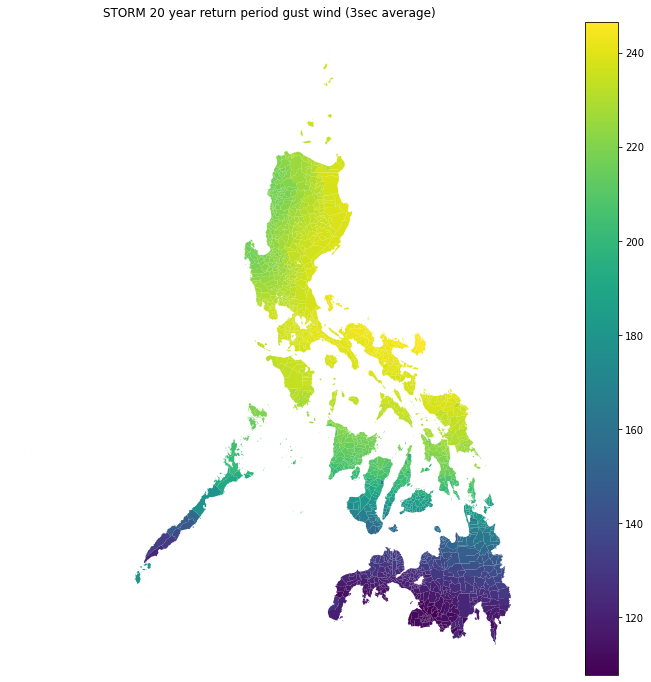

In [248]:
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1)
df_WIND_storm.plot(column='wind_3se_guest',ax=ax,legend=True)
leg = ax.get_legend()
 
plt.title('STORM 20 year return period gust wind (3sec average) ')
#leg.set_bbox_to_anchor((1.15,0.5))
ax.set_axis_off()
plt.show()

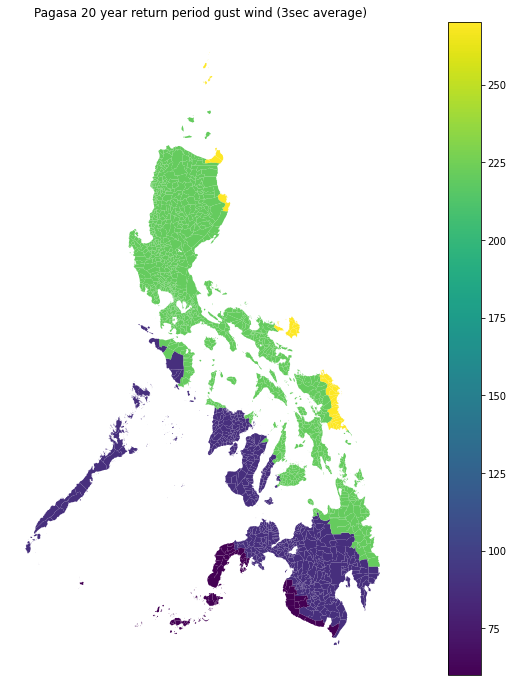

In [247]:
fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1)
df_WIND_pagasa.plot(column='wind_3se_guest',ax=ax,legend=True)
leg = ax.get_legend()
#leg.set_bbox_to_anchor((1.15,0.5))
ax.set_axis_off()
plt.title('Pagasa 20 year return period gust wind (3sec average) ')
plt.show()

### referances
https://library.wmo.int/doc_num.php?explnum_id=290 for conversion of 3second and 10 minutes wind

https://www.nature.com/articles/s41597-020-0381-2 source of windspeed data for different return periods (10 min average)

https://www.pagasa.dost.gov.ph/products-and-services/severe-wind-maps pagassa methedology 


In [265]:
sel_columns=['adm3_pcode', 'wind__10','wind__20', 'wind__30', 'wind__40', 'wind__50', 'wind__60', 'wind__70',
       'wind__80', 'wind__90', 'wind__100', 'wind__200', 'wind__300',
       'wind__400', 'wind__500', 'wind__600', 'wind__700', 'wind__800',
       'wind__900', 'wind__1000', 'wind__2000', 'wind__3000', 'wind__4000',
       'wind__5000', 'wind__6000', 'wind__7000', 'wind__8000', 'wind__9000',
       'wind__10000']

sel_columns2=['adm3_pcode', 'min_wind_0', 'max_wind_0',
              'min_wind_1', 'max_wind_1', 'min_wind_2', 
              'max_wind_2', 'min_wind_3','max_wind_3',
              'min_wind_4', 'max_wind_4']

In [ ]:
f_path = os.path.join(wor_dir,"data/all_predisaster_indicators.csv") 
df_predisasters = pd.read_csv(f_path)

#### summary statistics for vulnerability data

In [11]:
df_predisasters.agg(
    {
'Strong Roof/Strong Wall': ["min", "max", "median", "mean"],
'Strong Roof/Light Wall': ["min", "max", "median", "mean"],
'Strong Roof/Salvage Wall': ["min", "max", "median", "mean"],
'Light Roof/Strong Wall': ["min", "max", "median", "mean"],
'Light Roof/Light Wall': ["min", "max", "median", "mean"],
'Light Roof/Salvage Wall': ["min", "max", "median", "mean"],
'Salvaged Roof/Strong Wall': ["min", "max", "median", "mean"],
'Salvaged Roof/Light Wall': ["min", "max", "median", "mean"],
'Salvaged Roof/Salvage Wall': ["min", "max", "median", "mean"],
'Total # of Active HHs': ["min", "max", "median", "mean", "sum"],
'Housing Units': ["min", "max", "median", "mean", "sum"],
    })

,Strong Roof/Strong Wall,Strong Roof/Light Wall,Strong Roof/Salvage Wall,Light Roof/Strong Wall,Light Roof/Light Wall,Light Roof/Salvage Wall,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,Total # of Active HHs,Housing Units
min,0.641613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.800000e+01,1.000000e+00
max,98.137722,88.854248,6.970339,32.296651,83.996665,6.720500,2.080147,10.643890,5.283467,5.062600e+04,6.602490e+05
median,50.328882,24.698599,0.107759,0.477386,10.404162,0.042837,0.006580,0.048458,0.053179,1.866000e+03,7.437000e+03
mean,52.258812,27.629101,0.253646,1.394103,16.663956,0.119577,0.025856,0.116702,0.153680,2.537920e+03,1.336443e+04
sum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.179954e+06,2.201122e+07


In [12]:
df_predisasters[['Strong Roof/Strong Wall', 'Strong Roof/Light Wall',
                'Strong Roof/Salvage Wall', 'Light Roof/Strong Wall',
                'Light Roof/Light Wall', 'Light Roof/Salvage Wall',
                'Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall',
                'Salvaged Roof/Salvage Wall']].describe()

,Strong Roof/Strong Wall,Strong Roof/Light Wall,Strong Roof/Salvage Wall,Light Roof/Strong Wall,Light Roof/Light Wall,Light Roof/Salvage Wall,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall
count,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000
mean,52.258812,27.629101,0.253646,1.394103,16.663956,0.119577,0.025856,0.116702,0.153680
std,23.777737,17.518582,0.479815,2.642402,16.540668,0.263124,0.085091,0.344059,0.355218
min,0.641613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.048612,12.865942,0.032076,0.183559,3.270317,0.010483,0.000000,0.014218,0.007818
50%,50.328882,24.698599,0.107759,0.477386,10.404162,0.042837,0.006580,0.048458,0.053179
75%,72.651484,39.937297,0.267777,1.350208,26.179031,0.130100,0.025644,0.118559,0.161072
max,98.137722,88.854248,6.970339,32.296651,83.996665,6.720500,2.080147,10.643890,5.283467


In [278]:
def division(x, y):
    try:
        value =100* (x / y)
        
    except:
        value = np.nan
    
    return 100 if value>100 else value


# Setting the new damage threshold

df_predisasters["vulnerable_groups"] = df_predisasters.apply(lambda x: division(x["vulnerable_groups"], x["Total Pop"]), axis=1).values
#df_total["pantawid_pamilya_beneficiary"] = df_total.apply(lambda x: division(x["Total # of Active HHs"], x["Housing Units"]), axis=1).values
df_predisasters["pantawid_pamilya_beneficiary"] = df_predisasters.apply(lambda x: division(x["pantawid_total_pop"], x["Total Pop"]), axis=1).values

In [284]:
###STORM 
 
df_hazard=df_WIND_storm .filter(sel_columns)
df_hazard.rename(columns={'adm3_pcode':'Mun_Code'},inplace=True)
#df_hazard.query('Mun_Code=="PH184625000"')
dataframe_rp = pd.merge( df_predisasters,df_hazard,  how='left', left_on='Mun_Code', right_on ='Mun_Code')
df_total=dataframe_rp.filter(['Mun_Code', 'rainfall_Total', 'rainfall_max_6h',
                 'rainfall_max_24h', 'dis_track_min','landslide_per', 'stormsurge_per',
                 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg',
                 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 
                 'Yellow_per_LSbl', 'mean_slope','mean_elevation_m', 
                 'ruggedness_stdev', 'mean_ruggedness','slope_stdev',
                 'poverty_perc', 'with_coast', 'coast_length','Housing Units', 'Strong Roof/Strong Wall',
                 'Strong Roof/Light Wall', 'Strong Roof/Salvage Wall',
                 'Light Roof/Strong Wall', 'Light Roof/Light Wall',
                 'Light Roof/Salvage Wall', 'Salvaged Roof/Strong Wall',
                 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall',
                 'wind__10', 'wind__100', 'wind__1000', 'wind__10000', 'wind__20', 'wind__200',
                 'wind__2000', 'wind__30', 'wind__300', 'wind__3000', 'wind__40', 'wind__400',
                 'wind__4000', 'wind__50', 'wind__500', 'wind__5000', 'wind__60', 'wind__600',
                 'wind__6000', 'wind__70', 'wind__700', 'wind__7000', 'wind__80', 'wind__800',
                 'wind__8000', 'wind__90', 'wind__900', 'wind__9000',
                 'vulnerable_groups', 'pantawid_pamilya_beneficiary'])
dataframe_rp['dis_track_min']=100

df_total.rename(columns ={"rainfall_Total":"HAZ_rainfall_Total",
                                    'rainfall_max_6h':'HAZ_rainfall_max_6h',
                                    'rainfall_max_24h':'HAZ_rainfall_max_24h',
                                    'wind__10':'HAZ_wind_10',
                                    'wind__100':'HAZ_wind_100',
                                    'wind__1000':'HAZ_wind_1000',
                                    'wind__10000':'HAZ_wind_10000',
                                    'wind__20':'HAZ_wind_20',
                                    'wind__200':'HAZ_wind_200',
                                    'wind__2000':'HAZ_wind_2000',
                                    'wind__30':'HAZ_wind_30',
                                    'wind__300':'HAZ_wind_300',
                                    'wind__3000':'HAZ_wind_3000',
                                    'wind__40':'HAZ_wind_40',
                                    'wind__400':'HAZ_wind_400',
                                    'wind__4000':'HAZ_wind_4000',
                                    'wind__50':'HAZ_wind_50',
                                    'wind__500':'HAZ_wind_500',
                                    'wind__5000':'HAZ_wind_5000',
                                    'wind__60':'HAZ_wind_60',
                                    'wind__600':'HAZ_wind_600',
                                    'wind__6000':'HAZ_wind_6000',
                                    'wind__70':'HAZ_wind_70',
                                    'wind__700':'HAZ_wind_700',
                                    'wind__7000':'HAZ_wind_7000',
                                    'wind__80':'HAZ_wind_80',
                                    'wind__800':'HAZ_wind_800',
                                    'wind__8000':'HAZ_wind_8000',
                                    'wind__90':'HAZ_wind_90',
                                    'wind__900':'HAZ_wind_900',
                                    'wind__9000':'HAZ_wind_9000',
                                    'dis_track_min':'HAZ_dis_track_min',                       
                                    'landslide_per':'GEN_landslide_per',
                                    'stormsurge_per':'GEN_stormsurge_per',
                                    'Bu_p_inSSA':'GEN_Bu_p_inSSA',
                                    'Bu_p_LS':'GEN_Bu_p_LS',
                                    'Red_per_LSbldg':'GEN_Red_per_LSbldg',
                                    'Or_per_LSblg':'GEN_Or_per_LSblg',
                                    'Yel_per_LSSAb':'GEN_Yel_per_LSSAb',
                                    'RED_per_SSAbldg':'GEN_RED_per_SSAbldg',
                                    'OR_per_SSAbldg':'GEN_OR_per_SSAbldg',
                                    'Yellow_per_LSbl':'GEN_Yellow_per_LSbl',
                                    'mean_slope':'TOP_mean_slope',
                                    'mean_elevation_m':'TOP_mean_elevation_m',
                                    'ruggedness_stdev':'TOP_ruggedness_stdev',
                                    'mean_ruggedness':'TOP_mean_ruggedness',
                                    'slope_stdev':'TOP_slope_stdev',
                                    'poverty_perc':'VUL_poverty_perc',
                                    'with_coast':'GEN_with_coast',
                                    'coast_length':'GEN_coast_length',
                                    'Housing Units':'VUL_Housing_Units',
                                    'Strong Roof/Strong Wall':"VUL_StrongRoof_StrongWall",
                                    'Strong Roof/Light Wall':'VUL_StrongRoof_LightWall',
                                    'Strong Roof/Salvage Wall':'VUL_StrongRoof_SalvageWall',
                                    'Light Roof/Strong Wall':'VUL_LightRoof_StrongWall',
                                    'Light Roof/Light Wall':'VUL_LightRoof_LightWall',
                                    'Light Roof/Salvage Wall':'VUL_LightRoof_SalvageWall',
                                    'Salvaged Roof/Strong Wall':'VUL_SalvagedRoof_StrongWall',
                                    'Salvaged Roof/Light Wall':'VUL_SalvagedRoof_LightWall',
                                    'Salvaged Roof/Salvage Wall':'VUL_SalvagedRoof_SalvageWall',
                                    'vulnerable_groups':'VUL_vulnerable_groups',
                                    'pantawid_pamilya_beneficiary':'VUL_pantawid_pamilya_beneficiary'},inplace=True)

# Path to the windout
fpath = os.path.join(wor_dir,"data/model_input/model_input_for_returnperiod_storm.csv")
df_total.to_csv(fpath)


In [281]:
#PAGASA

df_hazard=df_WIND_pagasa .filter(sel_columns2)
df_hazard.rename(columns={'adm3_pcode':'Mun_Code'},inplace=True)
#df_hazard.query('Mun_Code=="PH184625000"')
dataframe_rp = pd.merge( df_predisasters,df_hazard,  how='left', left_on='Mun_Code', right_on ='Mun_Code')

df_total=dataframe_rp.filter(['Mun_Code', 'rainfall_Total', 'rainfall_max_6h',
                 'rainfall_max_24h', 'dis_track_min','landslide_per', 'stormsurge_per',
                 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg',
                 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 
                 'Yellow_per_LSbl', 'mean_slope','mean_elevation_m', 
                 'ruggedness_stdev', 'mean_ruggedness','slope_stdev',
                 'poverty_perc', 'with_coast', 'coast_length','Housing Units', 'Strong Roof/Strong Wall',
                 'Strong Roof/Light Wall', 'Strong Roof/Salvage Wall',
                 'Light Roof/Strong Wall', 'Light Roof/Light Wall',
                 'Light Roof/Salvage Wall', 'Salvaged Roof/Strong Wall',
                 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall',
                 'min_wind_0', 'max_wind_0', 'min_wind_1', 'max_wind_1', 'min_wind_2',
                 'max_wind_2', 'min_wind_3', 'max_wind_3', 'min_wind_4', 'max_wind_4',
                 'vulnerable_groups', 'pantawid_pamilya_beneficiary'])

dataframe_rp['dis_track_min']=100

df_total.rename(columns ={"rainfall_Total":"HAZ_rainfall_Total",
                                    'rainfall_max_6h':'HAZ_rainfall_max_6h',
                                    'rainfall_max_24h':'HAZ_rainfall_max_24h',
                                    'min_wind_0':'HAZ_wind_20_min',
                                    'max_wind_0':'HAZ_wind_20',
                                    'min_wind_1':'HAZ_wind_50_min',
                                    'max_wind_1':'HAZ_wind_50',
                                    'min_wind_2':'HAZ_wind_100_min',
                                    'max_wind_2':'HAZ_wind_100',
                                    'min_wind_3':'HAZ_wind_200_min',
                                    'max_wind_3':'HAZ_wind_200',
                                    'min_wind_4':'HAZ_wind_500_min',
                                    'max_wind_4':'HAZ_wind_500',                                    
                                    'dis_track_min':'HAZ_dis_track_min',                       
                                    'landslide_per':'GEN_landslide_per',
                                    'stormsurge_per':'GEN_stormsurge_per',
                                    'Bu_p_inSSA':'GEN_Bu_p_inSSA',
                                    'Bu_p_LS':'GEN_Bu_p_LS',
                                    'Red_per_LSbldg':'GEN_Red_per_LSbldg',
                                    'Or_per_LSblg':'GEN_Or_per_LSblg',
                                    'Yel_per_LSSAb':'GEN_Yel_per_LSSAb',
                                    'RED_per_SSAbldg':'GEN_RED_per_SSAbldg',
                                    'OR_per_SSAbldg':'GEN_OR_per_SSAbldg',
                                    'Yellow_per_LSbl':'GEN_Yellow_per_LSbl',
                                    'mean_slope':'TOP_mean_slope',
                                    'mean_elevation_m':'TOP_mean_elevation_m',
                                    'ruggedness_stdev':'TOP_ruggedness_stdev',
                                    'mean_ruggedness':'TOP_mean_ruggedness',
                                    'slope_stdev':'TOP_slope_stdev',
                                    'poverty_perc':'VUL_poverty_perc',
                                    'with_coast':'GEN_with_coast',
                                    'coast_length':'GEN_coast_length',
                                    'Housing Units':'VUL_Housing_Units',
                                    'Strong Roof/Strong Wall':"VUL_StrongRoof_StrongWall",
                                    'Strong Roof/Light Wall':'VUL_StrongRoof_LightWall',
                                    'Strong Roof/Salvage Wall':'VUL_StrongRoof_SalvageWall',
                                    'Light Roof/Strong Wall':'VUL_LightRoof_StrongWall',
                                    'Light Roof/Light Wall':'VUL_LightRoof_LightWall',
                                    'Light Roof/Salvage Wall':'VUL_LightRoof_SalvageWall',
                                    'Salvaged Roof/Strong Wall':'VUL_SalvagedRoof_StrongWall',
                                    'Salvaged Roof/Light Wall':'VUL_SalvagedRoof_LightWall',
                                    'Salvaged Roof/Salvage Wall':'VUL_SalvagedRoof_SalvageWall',
                                    'vulnerable_groups':'VUL_vulnerable_groups',
                                    'pantawid_pamilya_beneficiary':'VUL_pantawid_pamilya_beneficiary'},inplace=True)
# Path to the windout
fpath = os.path.join(wor_dir,"data/model_input/model_input_for_returnperiod_pagasa.csv")
df_total.to_csv(fpath)